# Recovering the first TESS Planet Candidate Using the *Lightkurve* Package

This tutorial is almost entirely from the [TESS *Lightkurve* Tutorial](https://colab.research.google.com/github/KeplerGO/lightkurve/blob/master/docs/source/tutorials/02-how-to-recover-the-first-tess-candidate.ipynb#scrollTo=Ly6zjNqvzIqW) written by Geert Barentsen.

This is a quick tutorial on how to get started using *Lightkurve* to access and analyze the TESS data. This tutorial takes a look at the target Pi Mensae (Tess Input Catalog ID 261136679) which was the first planet candidate discovered in the TESS data by [Huang et al. (2018)](https://arxiv.org/abs/1809.05967). We're going to use *Lightkurve* to rediscover the candidate.

To detect a transiting exoplanet, we observe the brightness of a star over time. A transiting exoplanet should create a dip in brightness corresponding to radial size of the orbiting planet. TESS takes images of ~200,000 stars every two minutes, and millions-to-billions stars every half hour. Pi Mensae is one of the stars that is observed every two minutes by the TESS mission. These observations are optical images, called Target Pixel Files (TPFs) and stored online for public access.

In [1]:
#! pip install lightkurve

In [2]:
from lightkurve import TessTargetPixelFile
import numpy as np

%matplotlib inline

In [3]:
#We use Lightkurve to download the file
tpf = TessTargetPixelFile('https://archive.stsci.edu/hlsps/tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00261136679-s01_tess_v1_tp.fits')

The `TessTargetPixelFile` class in *Lightkurve* has some handy commands for exploring the meta data of the TPF that you downloaded.

In [4]:
#Lightkurve also works with Kepler. Use this to check which mission you're working with.
tpf.mission

'TESS'

In [5]:
tpf.targetid #TIC id

261136679

We can use *Lightkurve* to look directly at the images in the TPF for Pi Mensae. Let's look at the TPF with the default TESS pipeline mask applied to select our target star.

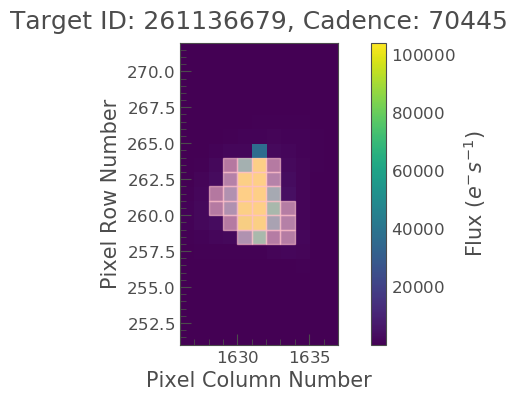

In [6]:
tpf.plot(aperture_mask=tpf.pipeline_mask)

We can see that this mask is not ideal, it doesn't include all of the pixels from our target star. We can use `numpy` to create a better mask that allows the position of the star to move on the CCD over time.

In [7]:
#Create a median image of the target object over time
#Google the documentation for np.nanmedian to see what `axis` means
median_image = np.nanmedian(tpf.flux, axis=0)

In [8]:
#Select pixels brighter than the 85th percentile in the median image for a new mask
aperture_mask = median_image > np.nanpercentile(median_image, 85)

In the following cell plot your new mask on the target pixel file. Does it cover all of the pixels of the target star?

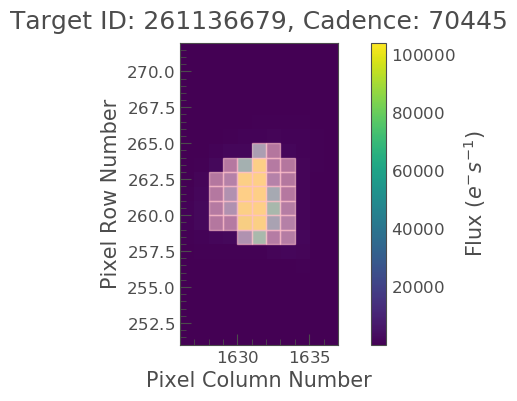

In [9]:
#Use the commands above to look at your new mask.
tpf.plot(aperture_mask=aperture_mask)

Now we can use the better aperture you made to extract the light curve from the TPFs with the `to_lightcurve()` function.

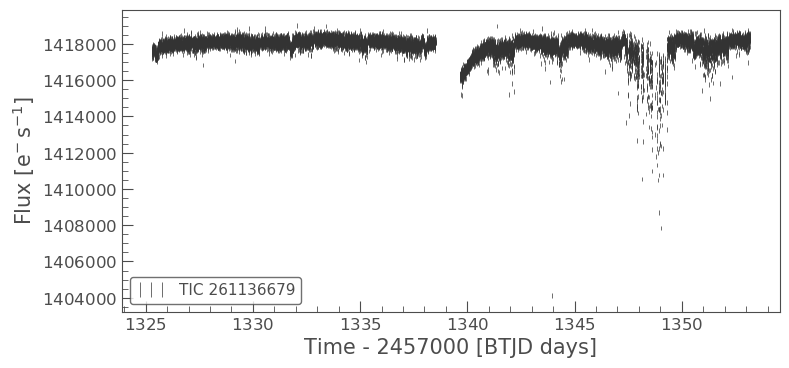

In [10]:
lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
lc.errorbar()

In the following cell plot the lightcurve from the default mask and the median percentile mask. Which lightcurve looks less noisy?

In [11]:
#lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
#lc.errorbar()

It's starting to look like there might be a planet in the data. Let's fold the lightcurve on the planet period. Look in [Huang et al. (2018)](https://arxiv.org/abs/1809.05967) to find the orbital period of the planet and the time of transit, known as t0.

In [12]:
huang_period = 6.2679
huang_t0 = 2458325.50400

//anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:594: LightkurveWarning: `t0` appears to be given in JD, however the light curve time uses BTJD (i.e. JD - 2457000).
  '(i.e. JD - 2457000).', LightkurveWarning)


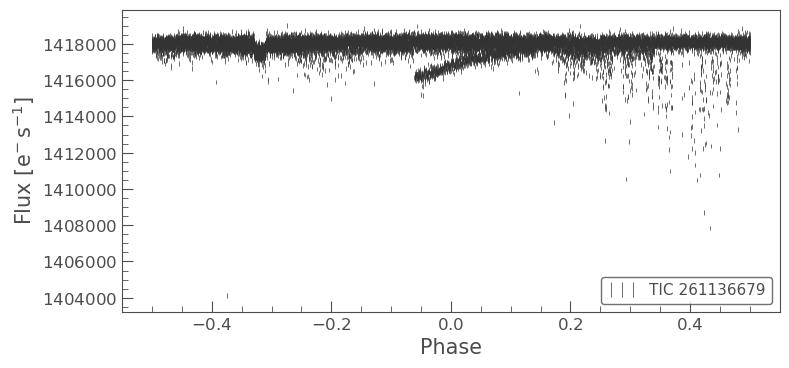

In [13]:
folded_lc = lc.fold(period=huang_period, t0 = huang_t0)
folded_lc.errorbar()

## Assignment

### Part 1

Head over to the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/) that Emilie showed us last week  or the ExoFoP website (https://exofop.ipac.caltech.edu/tess/view_toi.php). Select your favorite TESS planet (other than Pi Mensae). Use the TIC id to show the transit lightcurve here. Follow the lightkurve tutorial https://docs.lightkurve.org/tutorials/3-science-examples/exoplanets-identifying-transiting-planet-signals.html#1.-Downloading-a-Light-Curve-and-Removing-Long-Term-Trends, flatten the light curve, remove the outliers and fold the light curve at the detected period.

### Part 2

Pick another TESS planet, download and clean up the light curve as you did in the previous task. Search for the transit signal using the Box-Least-Square method in lightkurve (https://docs.lightkurve.org/tutorials/3-science-examples/exoplanets-identifying-transiting-planet-signals.html). See if you can recover the orbital period identified by the TESS team.

//anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:594: LightkurveWarning: `t0` appears to be given in JD, however the light curve time uses BTJD (i.e. JD - 2457000).
  '(i.e. JD - 2457000).', LightkurveWarning)


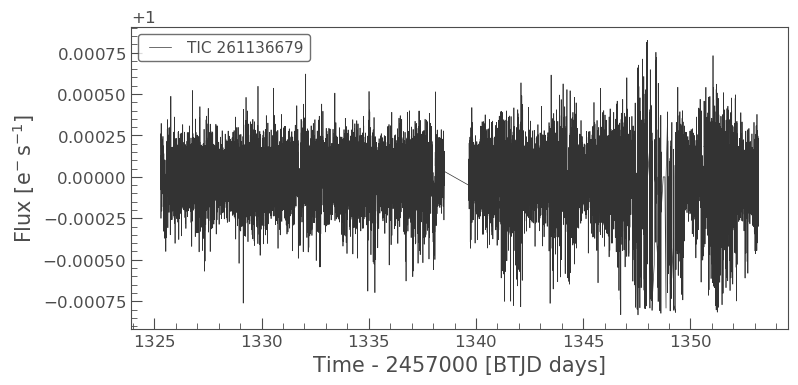

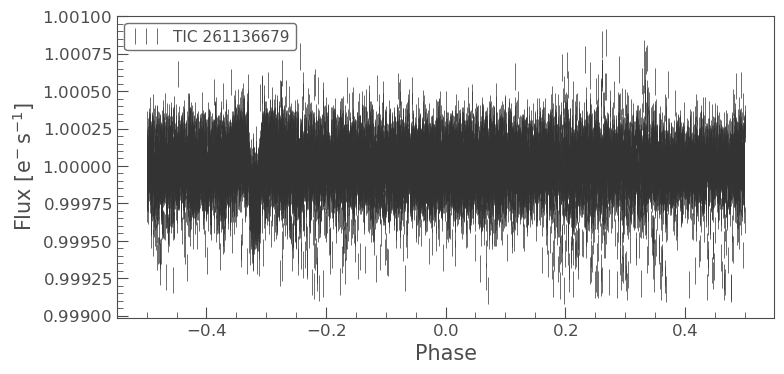

In [17]:
#let's detrend Pi Mensae
lc = lc.flatten(window_length=501).remove_outliers()
lc.plot()
folded_lc = lc.fold(period=huang_period, t0 = huang_t0)
folded_lc.errorbar()

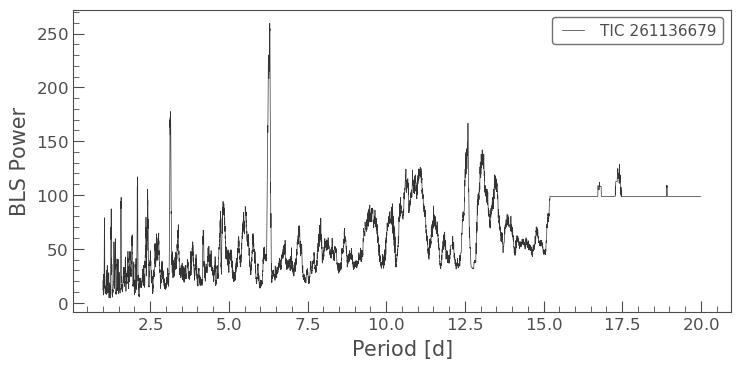

In [18]:
import numpy as np
# Create array of periods to search
period = np.linspace(1, 20, 10000)
# Create a BLSPeriodogram
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

In [21]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

# Check the value for period
planet_b_period

<Quantity 6.29962996 d>